In [23]:
!pip install catboost
# !pip install tabulate
# !pip install tqdm
# !pip install xgboost

In [0]:
import pandas as pd
import time
import calendar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
import re
from tqdm import tqdm
import pickle
# import hunga_bunga as hb

from keras.models import Sequential, Model
from keras.layers import Dense, Input
from keras.layers import LSTM, LeakyReLU

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor, VotingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
import lightgbm as lgbm
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor

# from helper_functions import *

import warnings
warnings.filterwarnings("ignore")

sns.set()
pd.set_option("display.precision", 1)
%matplotlib inline

In [25]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
train_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Predict Future Sales/data/sales_train_v2.csv')
test_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Predict Future Sales/data/test.csv')
items_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Predict Future Sales/data/items.csv')
items_cat_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Predict Future Sales/data/item_categories.csv')
shops_df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Predict Future Sales/data/shops.csv')

shops_df has some duplicated shop names with a little bit of mispell.<br>We'll fix it on the train & test data frames.

In [142]:
shops_df[shops_df['shop_id'].isin([0, 1, 10, 11, 57, 58])]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
10,Жуковский ул. Чкалова 39м?,10
11,Жуковский ул. Чкалова 39м²,11
57,"Якутск Орджоникидзе, 56",57
58,"Якутск ТЦ ""Центральный""",58


In [0]:
# 0 vs 57
train_df.loc[train_df.shop_id == 0, 'shop_id'] = 57
test_df.loc[test_df.shop_id == 0, 'shop_id'] = 57
# 1 vs 58
train_df.loc[train_df.shop_id == 1, 'shop_id'] = 58
test_df.loc[test_df.shop_id == 1, 'shop_id'] = 58
# 10 vs 11
train_df.loc[train_df.shop_id == 10, 'shop_id'] = 11
test_df.loc[test_df.shop_id == 10, 'shop_id'] = 11

We can extract shop city from the shop name and sub category from category name.<br>
Then, Label encode it.

In [0]:
shops_df['shop_city'] = shops_df['shop_name'].apply(lambda x: x.split(' ', 1)[0].strip("!"))
items_cat_df['sub_cat'] = items_cat_df['item_category_name'].apply(lambda x: x.split(' ', 1)[0])
le = LabelEncoder()
shops_df['shop_city'] = le.fit_transform(shops_df['shop_city'])
items_cat_df['sub_cat'] = le.fit_transform(items_cat_df['sub_cat'])

There are some items, that exist in the test set but not in the train set.<br>
We will address this issue later on, when we will need to attach data to these<br> 
items, such as price and count of sold items.

In [145]:
diff = list(set(test_df['item_id']).difference(set(train_df['item_id'])))
print('Number of "new" items', len(diff))

Number of "new" items 363


The test data is a set of all combinations of items and shops of all times.<br>
The train data contains only items that are sold, but not items which didn't sell.<br>
Thus the destribution of the train and the test data is different so we'll have to add to the train data all information about items that did not sell that month.

In [146]:
grouped_df = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    current_info = train_df[train_df.date_block_num == i]
    item = set(current_info['item_id'])
    shop = set(current_info['shop_id'])
    grouped_df.append(np.array(list(itertools.product([i], shop, item)), dtype='int16'))
    print('unique items: {0}, unique shops: {1}, num of combinations: {2}'.format(current_info['item_id'].nunique(),
                                                                             current_info['shop_id'].nunique(),
                                                                             (np.array(list(itertools.product([i], shop, item)), dtype='int16')).shape[0]))

grouped_df = pd.DataFrame(np.vstack(grouped_df), columns=cols)
grouped_df['date_block_num'] = grouped_df['date_block_num'].astype(np.int8)
grouped_df['shop_id'] = grouped_df['shop_id'].astype(np.int8)
grouped_df['item_id'] = grouped_df['item_id'].astype(np.int16)
grouped_df.sort_values(cols,inplace=True)

unique items: 8115, unique shops: 45, num of combinations: 365175
unique items: 8168, unique shops: 46, num of combinations: 375728
unique items: 8302, unique shops: 46, num of combinations: 381892
unique items: 8145, unique shops: 46, num of combinations: 374670
unique items: 8339, unique shops: 45, num of combinations: 375255
unique items: 8478, unique shops: 46, num of combinations: 389988
unique items: 8405, unique shops: 46, num of combinations: 386630
unique items: 8031, unique shops: 45, num of combinations: 361395
unique items: 7876, unique shops: 45, num of combinations: 354420
unique items: 8039, unique shops: 46, num of combinations: 369794
unique items: 8089, unique shops: 45, num of combinations: 364005
unique items: 8474, unique shops: 46, num of combinations: 389804
unique items: 7551, unique shops: 46, num of combinations: 347346
unique items: 7134, unique shops: 46, num of combinations: 328164
unique items: 7142, unique shops: 48, num of combinations: 342816
unique ite

## Aggregate the data to Months
Concat train and test.

In [0]:
def turn_df_monthly(df):
    '''
    A func. to aggregate the data to whole months since it is organized orignally by days.
    '''
    
    agg_dict = {'item_cnt_day' : 'sum', 'item_price' : 'mean'}
    df = df.groupby(['date_block_num', 'shop_id', 'item_id']).agg(agg_dict).reset_index()
    df.rename(columns={'item_cnt_day': 'item_cnt_month'}, inplace=True)
    df['item_cnt_month'] = df['item_cnt_month'].astype(np.float32)
    
    return df

In [0]:
train_df = turn_df_monthly(train_df)

There are some big differences between same items at the same shop in `item_price`. <br>I've decided to change all items with a price that is too low and update it with the mean price.
<br>Fix `item_price` feature:

In [0]:
train_df.item_price.clip(0, 3650, inplace=True) # Based on outliers analysis.

train_df['max_price'] = train_df.groupby(['item_id','shop_id'])['item_price'].transform('max')
# train_df['median_price'] = train_df.groupby(['item_id','shop_id'])['item_price'].transform('median')
train_df['mean_price'] = train_df.groupby(['item_id','shop_id'])['item_price'].transform('mean')

train_df['price_range'] = train_df['max_price'] - train_df['item_price']

# I've decided to impute mean price in places where the `item_price` is too low to be true.
train_df.loc[(train_df['price_range']>=1000)&(train_df['item_price']<=50),'item_price'] = train_df.loc[(train_df['price_range']>=1000)&(train_df['item_price']<=50),'mean_price']
train_df.drop(['max_price', 'price_range', 'mean_price'], axis=1, inplace=True)

In [0]:
grouped_df = grouped_df.merge(train_df, on=['date_block_num', 'shop_id', 'item_id'], how='left')
grouped_df['ID'] = -1

test_df['date_block_num'] = 34
test_df['item_price'] = 0
test_df['item_cnt_month'] = 0

# Concat train and test.
grouped_df = pd.concat([grouped_df, test_df], axis=0, ignore_index=True)

Add all extra features from `shop_df`, `item_cat_df`, and `item_df`.

In [0]:
grouped_df = grouped_df.merge(shops_df[['shop_id', 'shop_city']], on=['shop_id'], how='left')
grouped_df = grouped_df.merge(items_df[['item_id', 'item_category_id']], on=['item_id'], how='left')
grouped_df = grouped_df.merge(items_cat_df[['item_category_id', 'sub_cat']], on=['item_category_id'], how='left')

Add `year` and `month` feature:

In [0]:
grouped_df['year'] = (grouped_df['date_block_num'] / 12).astype(np.int8)
grouped_df['month'] = (grouped_df['date_block_num'] % 12).astype(np.int8)

Taking care of NaNs in `item_cnt_month` and `item_price` cols:

In [0]:
grouped_df['item_cnt_month'].fillna(0, inplace=True)
# As suggested by out outliers EDA and alot of the competition participants, we need to clip our target to (0,20)
# It makes a big difference when submitting.
grouped_df['item_cnt_month'].clip(0, 20, inplace=True)

In [0]:
# downcasting all float64 type features - save processing and training time.
for f in list(grouped_df.columns):
  if f in ['shop_id', 'date_block_num', 'item_category_id', 'year', 'month','shop_city','sub_cat']:
    grouped_df[f] = grouped_df[f].astype(np.int8)
  elif f in ['item_id']:
    grouped_df[f] = grouped_df[f].astype(np.int16)
  elif f in ['ID']:
    grouped_df[f] = grouped_df[f].astype(np.int32)
  else:
    grouped_df[f] = grouped_df[f].astype(np.float32)

In [156]:
grouped_df.dtypes

date_block_num         int8
shop_id                int8
item_id               int16
item_cnt_month      float32
item_price          float32
ID                    int32
shop_city              int8
item_category_id       int8
sub_cat                int8
year                   int8
month                  int8
dtype: object

-------------------------------------------------------------------------------

## Quick EDA

So as we can see, we have some negative values at cols `item_price` and `item_cnt_day`

In [1]:
# # Get rid of not not logical data.
# # For example sold items count that is negative.
print(train_df['item_price'][train_df['item_price']<0].count())
print(train_df['item_cnt_month'][train_df['item_cnt_month']<0].count())

In [0]:
train_df['item_cnt_month'].clip(lower=0, inplace=True)
train_df['item_price'].clip(lower=0, inplace=True)

In [2]:
# Get rid of duplicates
subset = ['date','date_block_num','shop_id','item_id']
print(train_df.duplicated(subset=subset).value_counts())
train_df.drop_duplicates(subset=subset, inplace=True)

## Dealing with outliers<br>
There are multiple ways to detect outliers.<br>
ploting a box plot shows remarkable outliers in `item_cnt_day` and in `item_price`.<br>

In [0]:
train_df.nlargest(7, 'item_cnt_day')

,year,date_block_num,shop_id,item_category_id,item_id,month,item_cnt_day,item_price,mean_price,median_price,ID
1581820,2015.0,33,12,9,11373,10,2253.0,401.4,364.8,281.6,-1
1552390,2015.0,32,12,80,9248,9,1644.0,1508.3,1410.7,1500.0,-1
1574074,2015.0,32,55,8,9249,9,1644.0,1506.9,1408.2,1500.0,-1
657978,2013.0,11,31,71,20949,12,1305.0,5.0,5.0,5.0,-1
1412903,2015.0,27,55,31,3730,4,1242.0,1700.0,1700.0,1700.0,-1
1226866,2014.0,23,31,71,20949,12,1209.0,5.0,5.0,5.0,-1
1296969,2015.0,24,55,31,5917,1,1127.0,45.0,96.5,59.0,-1


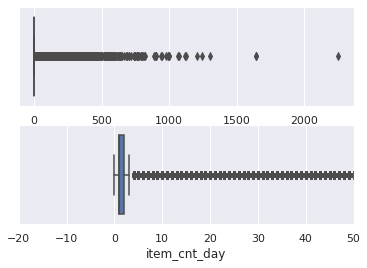

In [0]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharey=True)
axes[1].set(xlim=(-20, 50))
sns.boxplot(x=train_df['item_cnt_day'], ax=axes[0])
# Higher resolution to see the boxplot
sns.boxplot(x=train_df['item_cnt_day'], ax=axes[1])

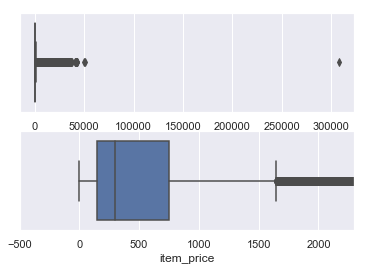

In [0]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharey=True)
axes[1].set(xlim=(-500, 2300))
sns.boxplot(x=train_df['item_price'], ax=axes[0])
# Higher resolution to see the boxplot
sns.boxplot(x=train_df['item_price'], ax=axes[1])

<b>Just a thought</b>, maybe remove outliers by computing <b>z-score</b>:

We chose to clip the `item_cnt_month` feature between (0, 20)<br>

In [0]:
z = np.abs(stats.zscore(train_df['item_cnt_day']))
train_df['item_cnt_day_zscore'] = z
threshold = 3
train_df[train_df['item_cnt_day_zscore'] < threshold][['item_cnt_day','item_cnt_day_zscore']].nlargest(5, 'item_cnt_day')

,item_cnt_day,item_cnt_day_zscore
16503,26.0,2.9
20004,26.0,2.9
23237,26.0,2.9
23498,26.0,2.9
24655,26.0,2.9
24800,26.0,2.9
27583,26.0,2.9
35822,26.0,2.9
35904,26.0,2.9
40301,26.0,2.9


In [0]:
z = np.abs(stats.zscore(train_df['item_price']))
train_df['item_price_zscore'] = z
threshold = 2
train_df[train_df['item_price_zscore'] < threshold][['item_price','item_price_zscore']].nlargest(5, 'item_price')

,item_price,item_price_zscore
1353839,3650.0,2.0
1361055,3650.0,2.0
7942,3649.0,2.0
420095,3649.0,2.0
699021,3649.0,2.0
920906,3649.0,2.0
1270553,3649.0,2.0
1287984,3649.0,2.0
1237601,3648.0,2.0
1338217,3648.0,2.0


## Adding Features

### Adding moving mean and standard deviation of `item_cnt_month` for different lagged periods.

In [0]:
def add_moving_mean_std(grouped_df, feat2grp, feat2grp_names, stats_periods, keep_lags=True):
  '''
  grouped_df: The dataframe.
  feat2grp: a list of features to group and to statictics on.
  feat2grp_names: a list of features' names to call the new created features with. list items must be string
  keep_lags: True to keep lagged features, False to remove those.
  stats_periods: a list of periods to do statistics on. for example [3] is for computing mean and std for 3 lags back.
  '''
  lags_range = [1,2,3,4,5,6,7,8,9,10,11,12]
  f_name = str()
  f_name_lst = []
  group = grouped_df.groupby(by = feat2grp).agg({'item_cnt_month':'sum'})

  for lag in tqdm(lags_range):
    for i in range(len(feat2grp_names)):
      f_name += feat2grp_names[i]+'_'
    f_name += 'lag'+str(lag)
    f_name_lst.append(f_name) # For dropping later if keep_lags is False

    tmp_group = group.copy().reset_index()
    tmp_group.loc[:, 'date_block_num'] += lag
    tmp_group.rename(columns={'item_cnt_month': f_name}, inplace=True)
    grouped_df = grouped_df.merge(tmp_group[feat2grp + [f_name]], how='left', on=feat2grp)
    grouped_df[f_name] = grouped_df[f_name].fillna(0)

    f_name = str() # reset f_name.

  for p in stats_periods:
    tmp_f_name_lst = f_name_lst[:p]
    grouped_df[tmp_f_name_lst[-1] + '_mean'] = grouped_df[tmp_f_name_lst].mean(axis=1)
    grouped_df[tmp_f_name_lst[-1] + '_std'] = grouped_df[tmp_f_name_lst].std(axis=1)
  
  if not keep_lags:
    grouped_df.drop(f_name_lst, axis=1, inplace=True)

  return grouped_df

In [164]:
grouped_df = add_moving_mean_std(grouped_df, ['date_block_num', 'item_id', 'shop_id'], ['item', 'shop'], stats_periods=[3,6,12], keep_lags=True)
grouped_df = add_moving_mean_std(grouped_df, ['date_block_num', 'item_id'], ['item'], stats_periods=[3,6,12], keep_lags=False)
grouped_df = add_moving_mean_std(grouped_df, ['date_block_num', 'shop_id'], ['shop'], stats_periods=[3,6,12], keep_lags=False)
grouped_df = add_moving_mean_std(grouped_df, ['date_block_num', 'item_category_id'], ['category'], stats_periods=[3,6,12], keep_lags=False)
grouped_df = add_moving_mean_std(grouped_df, ['date_block_num', 'sub_cat'], ['sub_cat'], stats_periods=[3,6,12], keep_lags=False)
grouped_df = add_moving_mean_std(grouped_df, ['date_block_num', 'shop_city'], ['city'], stats_periods=[3,6,12], keep_lags=False)

100%|██████████| 12/12 [00:36<00:00,  3.01s/it]


### Apply mean on different feature groups and then make lagged features out of it.<br> **Target feature**: `item_cnt_month`

In [0]:
def add_lagged_mean(grouped_df, feat2grp, feat2grp_names, lags_range, target_feat):

  f_name = str()
  f_name_lst = []
  group = grouped_df.groupby(by = feat2grp).agg({'item_cnt_month':'mean'})

  for lag in tqdm(lags_range):
    for i in range(len(feat2grp_names)):
      f_name += feat2grp_names[i]+'_'
    f_name += 'mean_lag_'+str(lag)
    f_name_lst.append(f_name) # For dropping later if keep_lags is False

    tmp_group = group.copy().reset_index()
    tmp_group.loc[:, 'date_block_num'] += lag
    tmp_group.rename(columns={'item_cnt_month': f_name}, inplace=True)
    grouped_df = grouped_df.merge(tmp_group[feat2grp + [f_name]], how='left', on=feat2grp)
    grouped_df[f_name] = grouped_df[f_name].fillna(0).astype(np.float16)

    f_name = str() # reset f_name.

  return grouped_df

In [3]:
grouped_df = add_lagged_mean(grouped_df, ['date_block_num'], ['block'], [1], 'item_cnt_month')
grouped_df = add_lagged_mean(grouped_df, ['date_block_num','item_id'], ['block', 'item'], [1,2,3,6,12], 'item_cnt_month')
grouped_df = add_lagged_mean(grouped_df, ['date_block_num', 'shop_id'], ['block', 'shop'], [1,2,3,6,12], 'item_cnt_month')
grouped_df = add_lagged_mean(grouped_df, ['date_block_num', 'item_category_id'], ['block', 'category'], [1], 'item_cnt_month')
grouped_df = add_lagged_mean(grouped_df, ['date_block_num', 'shop_city'], ['block', 'city'], [1], 'item_cnt_month')
grouped_df = add_lagged_mean(grouped_df, ['date_block_num', 'sub_cat','item_id'], ['block', 'subcat'], [1], 'item_cnt_month')

### Apply mean on different feature groups and then make lagged features out of it.<br> **Target feature**: `item_price`

In [157]:
group = train_df.groupby(by = ['item_id']).agg({'item_price':'mean'})
group.reset_index(inplace=True)
group.rename(columns={'item_price' : 'price_mean_item'}, inplace=True)
grouped_df = grouped_df.merge(group, on=['item_id'], how='left')
grouped_df['price_mean_item'] = grouped_df['price_mean_item'].astype(np.float16)

group = train_df.groupby(by = ['date_block_num', 'item_id']).agg({'item_price':'mean'})
group.reset_index(inplace=True)
group.rename(columns={'item_price' : 'price_mean_block_item'}, inplace=True)
grouped_df = grouped_df.merge(group, on=['date_block_num', 'item_id'], how='left')
grouped_df['price_mean_block_item'] = grouped_df['price_mean_block_item'].astype(np.float16)

group = train_df.groupby(by = ['date_block_num', 'shop_id', 'item_id']).agg({'item_price':'mean'})
group.reset_index(inplace=True)
group.rename(columns={'item_price' : 'price_mean_block_shop_item'}, inplace=True)
grouped_df = grouped_df.merge(group, on=['date_block_num', 'shop_id', 'item_id'], how='left')
grouped_df['price_mean_block_shop_item'] = grouped_df['price_mean_block_shop_item'].astype(np.float16)

def add_lagged_mean_price(grouped_df, lags_range, target_feat):

  tmp = grouped_df[['date_block_num','shop_id','item_id',target_feat]]
  for lag in tqdm(lags_range):
    shifted = tmp.copy()
    shifted.columns = ['date_block_num','shop_id','item_id', target_feat+'_lag_'+str(lag)]
    shifted['date_block_num'] += lag
    grouped_df = pd.merge(grouped_df, shifted, on=['date_block_num','shop_id','item_id'], how='left')

  return grouped_df

grouped_df = add_lagged_mean_price(grouped_df, [1,2,3,4,5,6], 'price_mean_item')
grouped_df = add_lagged_mean_price(grouped_df, [1,2,3,4,5,6], 'price_mean_block_item')
grouped_df = add_lagged_mean_price(grouped_df, [1,2,3,4,5,6], 'price_mean_block_shop_item')

lags_range = [1,2,3,4,5,6]
for lag in tqdm(lags_range):
  grouped_df['change_block_item_price_lag_' + str(lag)] = (grouped_df['price_mean_block_item_lag_' + str(lag)] - grouped_df['price_mean_item']) / grouped_df['price_mean_item']
  grouped_df['change_block_shop_item_price_lag_' + str(lag)] = (grouped_df['price_mean_block_shop_item_lag_' + str(lag)] - grouped_df['price_mean_item']) / grouped_df['price_mean_item']

100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


In [0]:
def select_trend(row):
  for lag in lags_range:
    if row['change_block_shop_item_price_lag_'+str(lag)]:
      return row['change_block_shop_item_price_lag_'+str(lag)]
  return 0

grouped_df['change_price_lag_block_shop_item'] = grouped_df.apply(select_trend, axis=1)
grouped_df['change_price_lag_block_shop_item'] = grouped_df['change_price_lag_block_shop_item'].astype(np.float16)
grouped_df['change_price_lag_block_shop_item'].fillna(0, inplace=True)

feat2drop = []
for lag in lags_range:
    feat2drop += ['price_mean_block_shop_item_lag_'+str(lag)]
    feat2drop += ['change_block_shop_item_price_lag_'+str(lag)]
grouped_df.drop(feat2drop, axis=1, inplace=True)

def select_trend(row):
  for lag in lags_range:
    if row['change_block_item_price_lag_'+str(lag)]:
      return row['change_block_item_price_lag_'+str(lag)]
  return 0

grouped_df['change_price_lag_block_item'] = grouped_df.apply(select_trend, axis=1)
grouped_df['change_price_lag_block_item'] = grouped_df['change_price_lag_block_item'].astype(np.float16)
grouped_df['change_price_lag_block_item'].fillna(0, inplace=True)

feat2drop = ['price_mean_item', 'price_mean_block_item', 'price_mean_block_shop_item', 'item_price']
for lag in lags_range:
    feat2drop += ['price_mean_block_item_lag_'+str(lag)]
    feat2drop += ['change_block_item_price_lag_'+str(lag)]
    feat2drop += ['price_mean_item_lag_'+str(lag)]
grouped_df.drop(feat2drop, axis=1, inplace=True)

### Shops' revenue moving mean (trend)

In [162]:
train_df['revenue'] = train_df['item_price'] * train_df['item_cnt_month']

group = train_df.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['block_shop_revenue']
group.reset_index(inplace=True)

grouped_df = pd.merge(grouped_df, group, on=['date_block_num','shop_id'], how='left')
grouped_df['block_shop_revenue'] = grouped_df['block_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'block_shop_revenue': ['mean']})
group.columns = ['shop_mean_revenue']
group.reset_index(inplace=True)

grouped_df = pd.merge(grouped_df, group, on=['shop_id'], how='left')
grouped_df['shop_mean_revenue'] = grouped_df['shop_mean_revenue'].astype(np.float32)

grouped_df['change_revenue'] = (grouped_df['block_shop_revenue'] - grouped_df['shop_mean_revenue']) / grouped_df['shop_mean_revenue']
grouped_df['change_revenue'] = grouped_df['change_revenue'].astype(np.float16)

def add_lagged_change_revenue(grouped_df, lags_range, target_feat):
  tmp = grouped_df[['date_block_num','shop_id','item_id',target_feat]]
  for lag in tqdm(lags_range):
    shifted = tmp.copy()
    shifted.columns = ['date_block_num','shop_id','item_id', target_feat+'_lag_'+str(lag)]
    shifted['date_block_num'] += lag
    grouped_df = pd.merge(grouped_df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
  return grouped_df
grouped_df = add_lagged_change_revenue(grouped_df, [1], 'change_revenue')

grouped_df.drop(['block_shop_revenue','shop_mean_revenue','change_revenue'], axis=1, inplace=True)

100%|██████████| 1/1 [00:06<00:00,  6.87s/it]


### Number of month from last sale of item and shop


In [0]:
def add_item_shop_months_from_last_sale(grouped_df):
  grouped_df.set_index(['item_id','shop_id', 'date_block_num'], inplace=True)
  grouped_df.sort_index(inplace=True)
  grouped_df.reset_index(inplace=True)
  grouped_df['prev_date_block_num'] = grouped_df.groupby(['item_id','shop_id'])['date_block_num'].shift(1)
  # grouped_df['item_price2'] = grouped_df.groupby(['item_id'], sort=False)['item_price'].apply(lambda x: x.ffill())
  grouped_df['months_from_last_sale'] = grouped_df['date_block_num'] - grouped_df['prev_date_block_num']
  grouped_df.drop('prev_date_block_num', axis=1, inplace=True)
  grouped_df.fillna(0, inplace=True)
  return grouped_df

grouped_df = add_item_shop_months_from_last_sale(grouped_df)

# grouped_df[['item_id', 'shop_id','date_block_num','months_from_last_sale']].isna().sum()

### Number of month from last sale of item



In [0]:
def add_item_months_from_last_sale(grouped_df):
  tmp_grouped_df = grouped_df[['item_id', 'date_block_num', 'item_cnt_month']].copy()
  tmp_grouped_df = tmp_grouped_df.groupby(by=['item_id','date_block_num']).agg({'item_cnt_month':'mean'})
  tmp_grouped_df.sort_index(inplace=True)
  tmp_grouped_df.reset_index(inplace=True)
  tmp_grouped_df['prev_date_block_num'] = tmp_grouped_df.groupby(['item_id'])['date_block_num'].shift(1)
  tmp_grouped_df['months_from_last_item_sale'] = tmp_grouped_df['date_block_num'] - tmp_grouped_df['prev_date_block_num']
  tmp_grouped_df.fillna(0, inplace=True)
  grouped_df = grouped_df.merge(tmp_grouped_df[['item_id','date_block_num','months_from_last_item_sale']],
                                               on=['item_id','date_block_num'], how='left')
  return grouped_df

grouped_df = add_item_months_from_last_sale(grouped_df)

# grouped_df[['item_id', 'shop_id','date_block_num','months_from_last_sale']].isna().sum()

### Additional Features

In [0]:
def days_in_month_feature(grouped_df):
  days = np.array([[0, 31],[1, 28], [2, 31], [3, 30], [4, 31], [5, 30], [6, 31], [7, 31], [8, 30], [9, 31], [10, 30], [11, 31]])
  days_df = pd.DataFrame(days, columns=['month','days'])
  grouped_df = grouped_df.merge(days_df[['month','days']], on='month', how='left')
  grouped_df['days'] /= 31
  grouped_df['days'] = grouped_df['days'].astype(np.float16)
  return grouped_df

grouped_df = days_in_month_feature(grouped_df)

### ** Add moving average of all combinations **

In [0]:
def num_weekends(grouped_df):
  ym = np.array([[2013, 1, 0], [2013, 2, 0], [2013, 3, 0],[2013, 4, 0],[2013, 5, 0],[2013, 6, 0],[2013, 7, 0],[2013, 8, 0],[2013, 9, 0],[2013, 10, 0],[2013, 11, 0],[2013, 12, 0],
               [2014, 1, 0], [2014, 2, 0], [2014, 3, 0],[2014, 4, 0],[2014, 5, 0],[2014, 6, 0],[2014, 7, 0],[2014, 8, 0],[2014, 9, 0],[2014, 10, 0],[2014, 11, 0],[2014, 12, 0],
               [2015, 1, 0], [2015, 2, 0], [2015, 3, 0],[2015, 4, 0],[2015, 5, 0],[2015, 6, 0],[2015, 7, 0],[2015, 8, 0],[2015, 9, 0],[2015, 10, 0],[2015, 11, 0],[2015, 12, 0]])

  weekend_df = pd.DataFrame(ym, columns=['year', 'month', 'num_weekends'])
  for y in range(2013, 2016):
    for m in range(1, 13):
      weekend_df.loc[(weekend_df['year']==y) & (weekend_df['month']==m),'num_weekends'] = len([1 for i in calendar.monthcalendar(y, m) if i[6] != 0])
  weekend_df['year'] = (weekend_df['year'] - 2013).astype(np.int8)
  weekend_df['month'] = (weekend_df['month'] - 1).astype(np.int16)
  grouped_df = grouped_df.merge(weekend_df, how='left', on=['year', 'month'])
  return grouped_df
  
grouped_df = num_weekends(grouped_df)

In [0]:
# downcasting all float64 type features - save processing and training time.
for f in list(grouped_df.columns):
  if f in ['shop_id', 'date_block_num', 'item_category_id', 'year', 'month','shop_city','sub_cat', 'months_from_last_sale', 'months_from_last_item_sale']:
    grouped_df[f] = grouped_df[f].astype(np.int8)
  elif f in ['item_id']:
    grouped_df[f] = grouped_df[f].astype(np.int16)
  elif f in ['ID']:
    grouped_df[f] = grouped_df[f].astype(np.int32)
  elif f in ['days']:
    grouped_df[f] = grouped_df[f].astype(np.float16)
  else:
    grouped_df[f] = grouped_df[f].astype(np.float32)

In [191]:
grouped_df.columns

Index(['item_id', 'shop_id', 'date_block_num', 'item_cnt_month', 'ID',
       'shop_city', 'item_category_id', 'sub_cat', 'year', 'month',
       'change_price_lag_block_shop_item', 'change_price_lag_block_item',
       'change_revenue_lag_1', 'item_shop_lag1', 'item_shop_lag2',
       'item_shop_lag3', 'item_shop_lag4', 'item_shop_lag5', 'item_shop_lag6',
       'item_shop_lag7', 'item_shop_lag8', 'item_shop_lag9', 'item_shop_lag10',
       'item_shop_lag11', 'item_shop_lag12', 'item_shop_lag3_mean',
       'item_shop_lag3_std', 'item_shop_lag6_mean', 'item_shop_lag6_std',
       'item_shop_lag12_mean', 'item_shop_lag12_std', 'item_lag3_mean',
       'item_lag3_std', 'item_lag6_mean', 'item_lag6_std', 'item_lag12_mean',
       'item_lag12_std', 'shop_lag3_mean', 'shop_lag3_std', 'shop_lag6_mean',
       'shop_lag6_std', 'shop_lag12_mean', 'shop_lag12_std',
       'category_lag3_mean', 'category_lag3_std', 'category_lag6_mean',
       'category_lag6_std', 'category_lag12_mean', 'catego

### Train Test Split

In [0]:
def ts_train_test_split(df_data, test_block, months_train, verbose=0, scale_f=False):
    df = df_data.copy()
    
    first_train_month = test_block - months_train
#     first_train_month=0
    test = df[df['date_block_num'] == test_block]
    # print(test.shape)
    train = df[(df['date_block_num'] >= first_train_month) & (df['date_block_num'] < test_block)]
    train.drop('date_block_num', axis=1, inplace=True)
    test.drop('date_block_num', axis=1, inplace=True)
    
    X_train = train.drop(['ID', 'item_cnt_month'], axis=1)
    y_train = train['item_cnt_month']
    X_test = test.drop(['ID', 'item_cnt_month'], axis=1)
    y_test = test['item_cnt_month']
    
    scaler = StandardScaler()
    if scale_f==True:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
    if verbose==1:
        print('X_train shape: {0} \nX_test shape: {1}'.format(X_train.shape,X_test.shape))

    return X_train, X_test, y_train, y_test, train, test 

### Feature selection

We could see from the cross-validation that a combination of 18 look-back periods, 1200 estimators (in tree based models) and max depth of 7, is the best performing yet.<br>
So we'll try some feature selection techniques and see what's best.

### Pearson Correlation - between features and target *did not use it*

In [0]:
def only_correlated_features(grouped_df, threshold=0.3):
  '''
  grouped_df - dataframe
  threshold - a constant that means: leave all features with higher correlation to the target than the threshold.

  returns the same dataframe but with only highly correlated features.
  categorical features left untouched - correlation is calculated only for continuous features
  '''
  
  corr = grouped_df.corr()
  corr2target = corr['item_cnt_day'].sort_values(ascending=False)
  corr2target = corr2target[corr2target > threshold]
  cat_features = ['item_id','shop_id','date_block_num','ID','item_category_id','year', 'month','shop_city','sub_cat']
  grouped_df_new = grouped_df.loc[:, (grouped_df.columns.isin(corr2target.index)) | (grouped_df.columns.isin(cat_features))]
  
  return grouped_df_new

In [199]:
cat_features = ['item_id','shop_id','date_block_num','ID','item_category_id','year', 'month','shop_city','sub_cat']
# corr_grouped_df = only_correlated_features(grouped_df, threshold=0.3)
X_train, X_val, y_train, y_val, train, test = ts_train_test_split(df_data=grouped_df, test_block=34, months_train=22, verbose=0, scale_f=True)
lgbm_model = LGBMRegressor(n_estimators=1000, max_depth=7, n_jobs=-1, random_state=42)
cat_features_indices = np.where(train.dtypes != np.float32)[0].tolist()
lgbm_model.fit(X_train, y_train, categorical_feature=cat_features_indices)
y_pred = lgbm_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)
print('MSE: ', str(mse))

MSE:  0.6850549107572523


In [0]:
def get_k_important_features(grouped_df, importances, k, im_type):
  '''
  input: data frame with features and data frame with `feature_importances` of the features from the first one.
         im_typwe - string: type of importance
  return: the data frame with only k most important features based on summing up importances from xgoost, catboost, lgbm regressors.
  '''
  must_features = ['item_id','shop_id','date_block_num','ID','item_category_id','year', 'month','shop_city','sub_cat', 'item_cnt_day']
  important_cols = importances.nlargest(k, im_type).index.tolist()
  important_cols.extend(must_features)
  return grouped_df[important_cols]

## Cross Validation - my experiments

In [4]:
# A dictionary to store all models' hyper params and accuracy.
# history = {}
# n_estimators_range = np.linspace(400, 1200, 5, dtype=int)
# max_depths = np.linspace(5, 12, 4, dtype=int)

# for i in range(30, 34):
#   best_mse_val = 100
#   best_train_range = None
#   best_n_estimators = None
#   best_max_depth = None
#   # LGBM

#   for tr in [12, 15, 18]:
#     X_train, X_val, y_train, y_val, train, test = ts_train_test_split(df_data=grouped_df, test_block=i, months_train=tr, verbose=0, scale_f=True)

#     for n_est in n_estimators_range:
#       for max_d in max_depths:
#         print('\nLGBM fitting...')
#         lgbm_model = LGBMRegressor(n_estimators=n_est, max_depth=max_d, n_jobs=-1)
#         lgbm_model.fit(X_train, y_train)
#         y_pred_train = lgbm_model.predict(X_train)
#         y_pred_val = lgbm_model.predict(X_val)
#         mae_train, mse_train = mean_absolute_error(y_train, y_pred_train), mean_squared_error(y_train, y_pred_train)
#         mae_val, mse_val = mean_absolute_error(y_val, y_pred_val), mean_squared_error(y_val, y_pred_val)
#         print('val block: ', i, 'train range: ', tr, ' n_estimators: ', n_est, ' max depth: ', max_d)
#         print('MSE train: ', str(mse_train))
#         print('MSE val: ', str(mse_val))
#         if mse_val < best_mse_val:
#           best_train_range, best_n_estimators, best_max_depth = tr, n_est, max_d
#           best_mse_val = mse_val

#         history['val_block_'+str(i)] = {'train_range': tr, 'n_estimators': n_est, 'max_depth': max_d, 'mae_train': mae_train, 'mse_train': mse_train,
#                                         'mae_val': mae_val, 'mse_val': mse_val}

#   print('best_train_range: ', best_train_range, 'best_n_estimators: ', best_n_estimators, ' best_max_depth: ', best_max_depth)
#   # CatBoost

#   # cat_grouped_df = grouped_df.copy()
  # categorical_features = ['item_id', 'shop_id', 'item_category_id', 'month', 'shop_city', 'sub_cat']
  # for f in categorical_features:
  #     cat_grouped_df[f] = cat_grouped_df[f].astype(str)

  # X_train, X_val, y_train, y_val, train, test = ts_train_test_split(df_data=cat_grouped_df, test_block=i, verbose=0, scale_f=False)
  # print(test.shape)
  # cat_features_indices = np.where(X_train.dtypes != np.float32)[0]
  # print('\nCatBoost fitting...')
  # catb_model = CatBoostRegressor(logging_level='Silent', cat_features=cat_features_indices)
  # catb_model.fit(X_train, y_train)
  # y_pred = catb_model.predict(X_val)
  # mae, mse = mean_absolute_error(y_val, y_pred), mean_squared_error(y_val, y_pred)
  # print('MAE: ', str(mae), 'MSE: ', str(mse),'\n')

  # XGBoost
  
  # X_train, X_val, y_train, y_val, test, train = ts_train_test_split(df_data=grouped_df, test_block=i, verbose=0, scale_f=True)
  
  # print('\nXGB fitting...')
  # xgb_model = XGBRegressor(max_depth=11, silent=True, n_jobs=-1, min_child_weight=0.5, 
  #                          subsample = 1, eta = 0.3, num_round = 1000, seed = 1, nthread = 16, n_estimators=500, random_state=42)
  # xgb_model.fit(X_train, y_train)
  # y_pred = xgb_model.predict(X_val)
  # mae, mse = mean_absolute_error(y_val, y_pred), mean_squared_error(y_val, y_pred)
  # print('MAE: ', str(mae), 'MSE: ', str(mse))
  
  # X_train, X_val, y_train, y_val, train, test = ts_train_test_split(df_data=grouped_df, test_block=i, verbose=0, scale_f=True)

#     print('\nLGBM fitting...')
#     lgbm_model = LGBMRegressor(n_estimators=400, max_depth=10, n_jobs=-1)
#     lgbm_model.fit(X_train, y_train)
#     y_pred = lgbm_model.predict(X_val)
#     y_val = y_scaler.inverse_transform(y_val)
#     print(y_val.shape)
#     y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
#     print(y_pred.shape)
#     mae, mse = mean_absolute_error(y_val, y_pred), mean_squared_error(y_val, y_pred)
#     print('MAE: ', str(mae), 'MSE: ', str(mse),'\n')
    
#     input_layer = Input(shape=(179,))
#     hidden_1 = Dense(units=1000, activation='relu')(input_layer)
#     hidden_2 = Dense(units=500, activation='relu')(hidden_1)
#     hidden_3 = Dense(units=200, activation='relu')(hidden_2)
#     hidden_4 = Dense(units=100, activation='relu')(hidden_3)
#     hidden_5 = Dense(units=50, activation='relu')(hidden_4)
#     hidden_6 = Dense(units=15, activation='relu')(hidden_5)
#     output_layer = Dense(units=1, activation='linear')(hidden_6)

#     model = Model(inputs=[input_layer], outputs=[output_layer])
#     model.compile(loss = 'mse', optimizer='adam')
#     model.summary()
#     model.fit(X_train, y_train, batch_size = 64, epochs = 3, verbose=1)
    
#     y_pred = model.predict(X_val)
#     mae, mse = mean_absolute_error(y_val, y_pred.reshape(-1)), mean_squared_error(y_val, y_pred.reshape(-1))
#     print('MAE: ', str(mae), 'MSE: ', str(mse),'\n')
    
#     print("TRAIN:", train_index, "TEST:", test_index)
#     print("TRAIN len:", len(train_index), "TEST len:", len(test_index))

#     print(np.max(y_train))
#     print(np.min(y_train))
#     print(np.max(y_val))
#     print(np.min(y_val))
#     print(type(X_train))
# #     [['item_price1', 'lag1', 'lag2', 'lag3', 'lag4',
# #        'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'lag11', 'lag12',
# #        'item_cnt_mean2', 'item_cnt_mean3', 'item_cnt_mean6', 'item_cnt_mean8',
# #        'item_cnt_mean12', 'item_price_mean3', 'item_price_mean6',
# #        'item_price_mean9', 'item_price_mean12', 'item_price1_mean',
# #        'item_price1_median', 'item_cnt_day_sum', 'item_cnt_day_mean',
# #        'cat_cnt_mean3', 'cat_cnt_mean6', 'cat_cnt_mean12']].describe()
#     print(X_val.shape)
#     print(y_train.shape)
#     print(y_val.shape)

## LGBM - model

In [0]:
def appeared_past_year(X_train, submission, test_block_num):
    
    # get only the data from the past 12 months.
#     x_test_12 = x_test[(x_test['date_block_num']>=test_year-13) & (x_test['date_block_num']<=test_year-1)]
#     if submission[submission['item_id'].isin(diff)]
    # get the unique values of item_id's from 
    past_year_items = list(X_train['item_id'].unique())
    
    # put zero if item havn't been sold for 12 months.
    submission.loc[(~submission['item_id'].isin(past_year_items))&(~submission['item_id'].isin(diff)), 'item_cnt_month'] = 0
    
    return submission

In [200]:
y_pred.shape

(214200,)

In [0]:
def make_submission_file(test, y_pred, X_train, nn=False):
    # if nn == True:
    #     pred_df = pd.DataFrame(data=y_pred.reshape(-1), columns=['item_cnt_month'])
    pred_df = pd.DataFrame(data=y_pred, columns=['item_cnt_month'])
    test.reset_index(inplace=True)
    submission = pd.concat([test[['ID','item_id']], pred_df], axis=1,names=['ID','item_id','item_cnt_month'])
    
#     submission = appeared_past_year(X_train=X_train, submission=submission, test_block_num=34)
    
    submission.drop('item_id', axis=1, inplace=True)
    submission.reset_index(inplace=True)
    submission.sort_values(by='ID', inplace=True)
    print('Creatin submission file...')
    submission.to_csv('submission_lgb.csv', index=False)
    return submission

In [202]:
pred_df = make_submission_file(test, y_pred, X_train)

Creatin submission file...
